# Bank Dataset — CatBoost classification

**Short description**  
This notebook trains a `CatBoostClassifier` on the Playground / Bank dataset, evaluates with ROC AUC and produces a `submission.csv`. The implementation is based on the provided baseline script.

## What this notebook does
1. Load train/test CSVs.
2. Split training data into train/validation.
3. Identify categorical features automatically.
5. Train a `CatBoostClassifier` (binary classification) with bayesian hyperparemeters tuning, AUC evaluation, early stopping and class_weights.
6. Calibrate probabilities
7. Score validation set (ROC AUC) and predict test set probabilities.
8. Save `submission.csv` with columns `id` and `y`.


In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from bayes_opt import BayesianOptimization

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [5]:
df_train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [6]:
df_train.shape

(750000, 18)

In [7]:
df_train["y"].value_counts(normalize=True)

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64

In [8]:
value_counts = df_train['y'].value_counts()

In [9]:
class_weights= [1, value_counts[0] / value_counts[1]]
class_weights

[1, 7.288391830961012]

In [10]:
X = df_train.drop(columns=['y', 'id'])
y = df_train['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [58]:
pbounds = {
          'depth': (4, 10),
          'border_count': (128, 255),
          'iterations': (500, 2000),

          'learning_rate': (0.01, 0.1),
          'l2_leaf_reg': (1, 20),
          'random_strength': (0.0, 8.0),
          'bagging_temperature': (0.0, 1.0),
}

def objective(depth, border_count, iterations, learning_rate, l2_leaf_reg,
              random_strength, bagging_temperature):
    model = CatBoostClassifier(
        depth=int(depth),
        border_count = int(border_count),
        iterations = int(iterations),    
        
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,

        loss_function='Logloss',
        task_type='GPU',
        eval_metric='AUC',        
        random_seed=42,
        verbose=int(iterations)//2, 
        class_weights=class_weights,
    )

    model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          cat_features=cat_features,
          use_best_model=True)

    
    
    auc = model.get_best_score()['validation']['AUC']
    
    return auc # maximize auc

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=3, n_iter=7)
best_params = optimizer.max['params']

|   iter    |  target   |   depth   | border... | iterat... | learni... | l2_lea... | random... | baggin... |
-------------------------------------------------------------------------------------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9257208	best: 0.9257208 (0)	total: 55.7ms	remaining: 1m 28s
798:	total: 31.6s	remaining: 31.5s
1596:	test: 0.9668501	best: 0.9668501 (1596)	total: 1m 3s	remaining: 0us
bestTest = 0.9668501019
bestIteration = 1596
| 2         | 0.9668501 | 6.2472407 | 248.74071 | 1597.9909 | 0.0638792 | 3.9643541 | 1.2479561 | 0.0580836 |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9357837	best: 0.9357837 (0)	total: 126ms	remaining: 3m 17s
781:	total: 1m 3s	remaining: 1m 3s
1561:	test: 0.9642878	best: 0.9642878 (1561)	total: 2m 6s	remaining: 0us
bestTest = 0.9642878175
bestIteration = 1561
| 3         | 0.9642878 | 9.1970568 | 204.34160 | 1562.1088 | 0.0118526 | 19.428287 | 6.6595411 | 0.2123391 |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9175194	best: 0.9175194 (0)	total: 44.5ms	remaining: 42.5s
478:	total: 15.5s	remaining: 15.5s
955:	test: 0.9645591	best: 0.9645591 (955)	total: 30.8s	remaining: 0us
bestTest = 0.9645591378
bestIteration = 955
| 4         | 0.9645591 | 5.0909498 | 151.29237 | 956.36336 | 0.0572280 | 9.2069553 | 2.3298331 | 0.6118528 |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9314594	best: 0.9314594 (0)	total: 92.6ms	remaining: 2m 27s
796:	total: 48.9s	remaining: 48.8s
1592:	test: 0.9661451	best: 0.9661451 (1592)	total: 1m 36s	remaining: 0us
bestTest = 0.9661450982
bestIteration = 1592
| 5         | 0.9661450 | 8.6821930 | 249.71027 | 1593.4481 | 0.0268419 | 5.1290011 | 1.9013931 | 0.6986388 |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9175194	best: 0.9175194 (0)	total: 43.2ms	remaining: 1m 9s
802:	total: 25.8s	remaining: 25.7s
1604:	test: 0.9663860	best: 0.9663860 (1604)	total: 51.9s	remaining: 0us
bestTest = 0.9663860202
bestIteration = 1604
| 6         | 0.9663860 | 5.7651196 | 242.63582 | 1605.1735 | 0.0698154 | 4.6239908 | 4.0931888 | 0.2732118 |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9036230	best: 0.9036230 (0)	total: 35.9ms	remaining: 57.7s
803:	total: 21s	remaining: 21s
1606:	test: 0.9659063	best: 0.9659063 (1606)	total: 42s	remaining: 0us
bestTest = 0.965906322
bestIteration = 1606
| 7         | 0.9659063 | 4.0       | 255.0     | 1607.3967 | 0.0823278 | 3.5007480 | 6.5410577 | 0.0       |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9291432	best: 0.9291432 (0)	total: 69.8ms	remaining: 1m 51s
795:	test: 0.9646564	best: 0.9646564 (795)	total: 38.6s	remaining: 38.5s
1590:	test: 0.9660888	best: 0.9660888 (1590)	total: 1m 17s	remaining: 0us
bestTest = 0.9660887718
bestIteration = 1590
| 8         | 0.9660887 | 7.3932803 | 234.74696 | 1591.1795 | 0.0282963 | 7.2617246 | 0.2090717 | 0.0753384 |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9175194	best: 0.9175194 (0)	total: 44.6ms	remaining: 1m 11s
803:	total: 26.1s	remaining: 26s
1605:	test: 0.9661450	best: 0.9661450 (1605)	total: 51.9s	remaining: 0us
bestTest = 0.966144979
bestIteration = 1605
| 9         | 0.9661449 | 5.9593066 | 233.49685 | 1606.4435 | 0.0843623 | 19.549428 | 3.4627895 | 0.9484351 |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9379295	best: 0.9379295 (0)	total: 128ms	remaining: 3m 26s
803:	total: 1m 3s	remaining: 1m 3s
1606:	test: 0.9672852	best: 0.9672927 (1545)	total: 2m 8s	remaining: 0us
bestTest = 0.967292726
bestIteration = 1545
Shrink model to first 1546 iterations.
| 10        | 0.9672927 | 9.4548001 | 249.02756 | 1607.6769 | 0.0613795 | 15.533548 | 0.3143668 | 0.4354162 |


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9175194	best: 0.9175194 (0)	total: 44.1ms	remaining: 1m 10s
800:	test: 0.9656430	best: 0.9656430 (800)	total: 26.1s	remaining: 26s
1599:	test: 0.9666980	best: 0.9666980 (1599)	total: 51.8s	remaining: 0us
bestTest = 0.9666979909
bestIteration = 1599
| 11        | 0.9666979 | 5.8555984 | 248.42697 | 1600.2028 | 0.0926453 | 18.117016 | 6.8622262 | 0.5376074 |


In [12]:
model = CatBoostClassifier(
        depth=9,
        border_count = 249,
        iterations = 1607,    
        
        learning_rate=0.06,
        l2_leaf_reg=15.534,
        random_strength=0.314,
        bagging_temperature=0.436,

        loss_function='Logloss',
        eval_metric='AUC',
        task_type='GPU',            
        random_seed=42,
        verbose=803, 
        class_weights=class_weights,
        # depth=int(best_params['depth']),
        # border_count = int(best_params['border_count']),
        # iterations = int(best_params['iterations']),    
        
        # learning_rate=best_params['learning_rate'],
        # l2_leaf_reg=best_params['l2_leaf_reg'],
        # random_strength=best_params['random_strength'],
        # bagging_temperature=best_params['bagging_temperature'],

        # loss_function='Logloss',
        # eval_metric='AUC',
        # task_type='GPU',            
        # random_seed=42,
        # verbose=int(best_params['iterations'])//2, 
        # class_weights=class_weights,
    )

model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          cat_features=cat_features,
          use_best_model=True)


y_pred_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Validation ROC AUC: {auc}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9379295	best: 0.9379295 (0)	total: 379ms	remaining: 10m 7s
803:	total: 1m 3s	remaining: 1m 3s
1606:	test: 0.9673342	best: 0.9673369 (1600)	total: 2m 8s	remaining: 0us
bestTest = 0.9673368931
bestIteration = 1600
Shrink model to first 1601 iterations.
Validation ROC AUC: 0.9673368887802843


In [13]:
model.save_model('/kaggle/working/catboost_model.cbm')

# Calibrate probabilities

In [22]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt 
from sklearn.metrics import brier_score_loss

def rate_calibration(y_test, y_pred_prob):    
    prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy='uniform')
    auc = roc_auc_score(y_test, y_pred_prob)

    print("AUC:", auc)
    print('Brier:', brier_score_loss(y_test, y_pred_prob))


    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label='CatBoost')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Predicted proba')
    plt.ylabel('True proba')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

### Without calibration

AUC: 0.9673368887802843
Brier: 0.0718402327379518


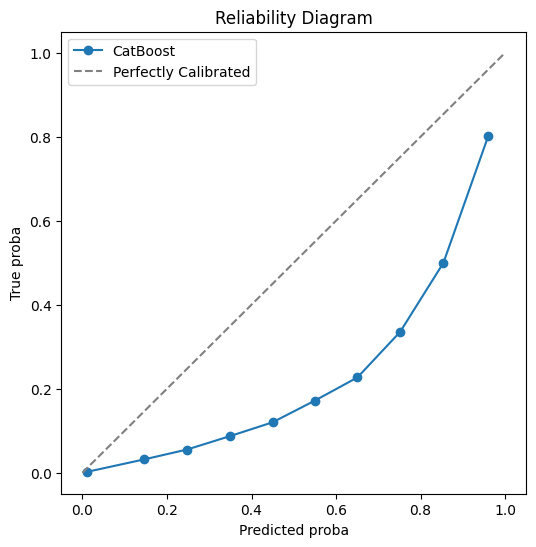

In [23]:
rate_calibration(y_test, y_pred_prob)

### the model overestimates the probability

### Plat scaling

AUC: 0.9673368887802843
Brier: 0.04676716133390398


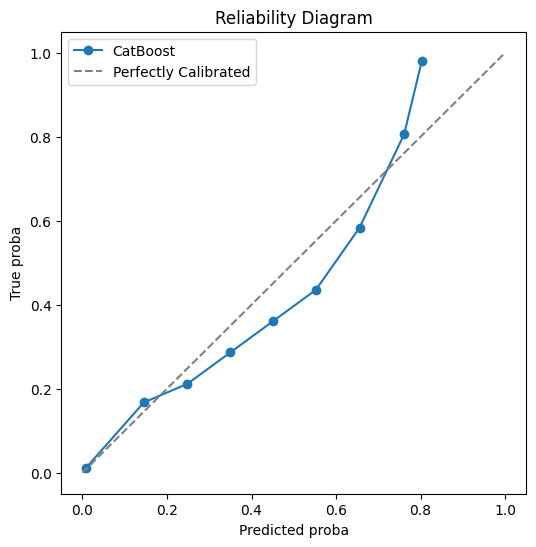

In [24]:
from sklearn.calibration import CalibratedClassifierCV
cal_platt = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
cal_platt.fit(X_test, y_test)
y_test_prob_cal = cal_platt.predict_proba(X_test)[:, 1]
rate_calibration(y_test, y_test_prob_cal)

### Isotonic regression

AUC: 0.9675307545230452
Brier: 0.04521765764505144


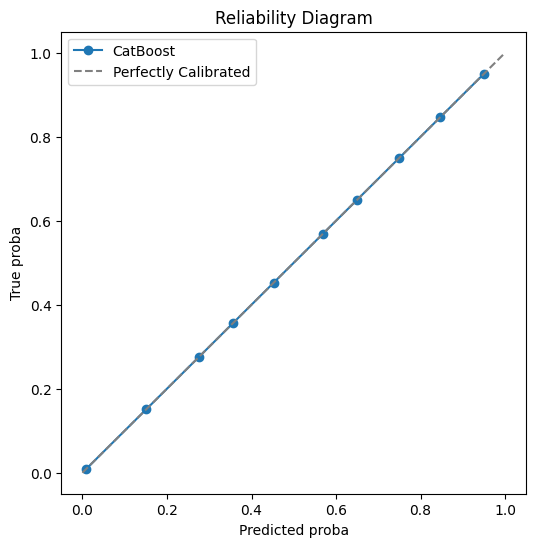

In [25]:
cal_iso = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
cal_iso.fit(X_test, y_test)
y_pred_prob_cal = cal_iso.predict_proba(X_test)[:, 1]
rate_calibration(y_test, y_pred_prob_cal)

# Predict Test

In [27]:
test_ids = df_test["id"]
X_test = df_test.drop(columns=["id"])

y_pred = cal_iso.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({"id": test_ids, "y": y_pred})
submission.to_csv("/kaggle/working/submission.csv", index=False)

In [28]:
submission.head()

,id,y
0,750000,0.000698
1,750001,0.087612
2,750002,0.000095
3,750003,0.000000
4,750004,0.029928
